# Introduction to Embeddings

This notebook provides a thorough introduction to the concept of embeddings.

## Setup libraries and functions.

We start by importing various libraries needed.

In [1]:
# Plots displayed inline in notebook
%matplotlib inline

# Make Python 3 consistent
from __future__ import print_function, division

# Make help libraries available
import sys

sys.path.append('/home/ubuntu/personal-libraries')

# Set visible devices, so as to just use a single GPU.
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import pandas as pd
import numpy as np

from operator import itemgetter
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input, Dense, Flatten, merge, Dropout
from keras.layers.merge import dot, add, concatenate
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.optimizers import Adam

from keras import backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


Setup paths and batch size. We work with the movielens dataset, and utilise the small dataset at first.

In [3]:
#path = "data/ml-20m/"
path = "data/movielens/ml-latest-small/"
model_path = 'models/recommender-intro/'

batch_size = 64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [4]:
ratings = pd.read_csv(path + 'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [6]:
movie_names = pd.read_csv(path + 'movies.csv').set_index('movieId')['title'].to_dict()

Define users and movies (as ids)

In [7]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

We define two dictionaries mapping each user and movie to a continous ordered integer.

In [8]:
userid2idx = {o:i for i, o in enumerate(users)}
movieid2idx = {o:i for i, o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [9]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

To get an overview of the structure of the data, we consider the max and min values.

In [10]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
                                            ratings.userId.max(),
                                            ratings.movieId.min(),
                                            ratings.movieId.max())

user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

So we have 671 users mapped to continous IDs and 9066 movies mapped to continous IDs. We check by considering the length of the objects.

In [11]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

We specify the number of latent factors in each embedding. This is a free parameter.

In [12]:
n_factors = 50

In [13]:
# Specify numpy seed, such that we get the same random sample each time
np.random.seed = 42

Randomly split into training and validation.

In [14]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [15]:
g = ratings.groupby('userId')['rating'].count()
topUsers = g.sort_values(ascending = False)[:15]

In [16]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending = False)[:15]

In [17]:
top_r = ratings.join(topUsers, rsuffix = '_r', how = 'inner', on = 'userId')

In [18]:
top_r = top_r.join(topMovies, rsuffix = '_r', how = 'inner', on = 'movieId')

In [19]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc = np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


We can then consider the intuition of collavborative filtering in Excel.

In [20]:
from IPython.display import FileLink
FileLink('collab_filter.xlsx')

D:\anlaursen\libraries\deep-learning-intro\embedding-intro\collab_filter.xlsx

## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works. We build two simple embeddings, one for users and one for movies. Note the onedimensional input. Also note that we add regularisation.

In [21]:
user_in = Input(shape=(1, ), dtype = 'int64', name = 'user_in')
u = Embedding(n_users, n_factors, input_length = 1, embeddings_regularizer = l2(1e-4))(user_in)
movie_in = Input(shape=(1, ), dtype = 'int64', name = 'movie_in')
m = Embedding(n_movies, n_factors, input_length = 1, embeddings_regularizer = l2(1e-4))(movie_in)

We then merge the two input layers via the dotproduct of the two. Note in this case of collaborative filtering for recomender systems, we use embeddings of users and movies to save computation time. We could have one hot encoded the layers, but that would gie us giant matrices to multiply. Instead we use an embedding representation.

In [22]:
# Define model layers
# Note that axes has to be set to 2! Remember the order is (batches, channels, dim1)
x = dot([u, m], 2)
x = Flatten()(x)

# Initialise and compile the model
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss = 'mse')

Let's consider the model.

In [23]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

Train the model for a single epoch.

In [24]:
model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 1, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80041 samples, validate on 19963 samples
Epoch 1/1
80041/80041 [==============================] - 8s - loss: 9.9172 - val_loss: 4.2515


Increase the learning rate and run for 3 more epochs.

In [25]:
model.optimizer.lr = 0.01

model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 3, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80041 samples, validate on 19963 samples
Epoch 1/3
80041/80041 [==============================] - 5s - loss: 3.1452 - val_loss: 2.8117
Epoch 2/3
80041/80041 [==============================] - 5s - loss: 2.4247 - val_loss: 2.6116
Epoch 3/3
80041/80041 [==============================] - 5s - loss: 2.2578 - val_loss: 2.5682


Finally lower the learning rate again and train for 6 more epochs.

In [26]:
model.optimizer.lr=0.001
model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 6, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80041 samples, validate on 19963 samples
Epoch 1/6
80041/80041 [==============================] - 5s - loss: 2.1956 - val_loss: 2.5583
Epoch 2/6
80041/80041 [==============================] - 5s - loss: 2.1581 - val_loss: 2.5479
Epoch 3/6
80041/80041 [==============================] - 5s - loss: 2.1299 - val_loss: 2.5468
Epoch 4/6
80041/80041 [==============================] - 5s - loss: 2.1021 - val_loss: 2.5458
Epoch 5/6
80041/80041 [==============================] - 5s - loss: 2.0783 - val_loss: 2.5555
Epoch 6/6
80041/80041 [==============================] - 5s - loss: 2.0538 - val_loss: 2.5681


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

So we start by defining an embedding input layer.

In [27]:
def embedding_input(name, n_in, n_out, reg):
    
    inp = Input(shape=(1, ), dtype = 'int64', name = name)
    return inp, Embedding(n_in, n_out, input_length = 1, embeddings_regularizer = l2(reg))(inp)

And then create the actual embedding layers.

In [28]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

We then ddefine the bias terms. Note that this is just a one dimensional output embedding.

In [29]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length = 1)(inp)
    return Flatten()(x)

We then create the actual bias layers.

In [30]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

We then merge the input embeddings as we did before via the dot product, but now we also add the movie and user bias layers.

In [31]:
x = dot([u, m], 2)
x = Flatten()(x)
x = add([x, ub])
x = add([x, mb])

model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss = 'mse')

Let's inspect the model.

In [32]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

We then train the model for a single epoch with the default learning rate.

In [33]:
model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 1, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80041 samples, validate on 19963 samples
Epoch 1/1
80041/80041 [==============================] - 7s - loss: 8.9274 - val_loss: 3.5458


Next we increase the learning rate and train for 6 more epochs.

In [34]:
model.optimizer.lr = 0.01

model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 6, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80041 samples, validate on 19963 samples
Epoch 1/6
80041/80041 [==============================] - 6s - loss: 2.6085 - val_loss: 2.2922
Epoch 2/6
80041/80041 [==============================] - 6s - loss: 1.9969 - val_loss: 2.0901
Epoch 3/6
80041/80041 [==============================] - 6s - loss: 1.8328 - val_loss: 1.9995
Epoch 4/6
80041/80041 [==============================] - 6s - loss: 1.7369 - val_loss: 1.9235
Epoch 5/6
80041/80041 [==============================] - 6s - loss: 1.6554 - val_loss: 1.8589
Epoch 6/6
80041/80041 [==============================] - 6s - loss: 1.5808 - val_loss: 1.7949


Let's run for 6 more epochs.

Let's decrease the learning rate and run for 20 more epochs.

In [35]:
model.optimizer.lr = 0.001

model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 30, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80041 samples, validate on 19963 samples
Epoch 1/30
80041/80041 [==============================] - 6s - loss: 1.5085 - val_loss: 1.7280
Epoch 2/30
80041/80041 [==============================] - 6s - loss: 1.4388 - val_loss: 1.6689
Epoch 3/30
80041/80041 [==============================] - 6s - loss: 1.3713 - val_loss: 1.6111
Epoch 4/30
80041/80041 [==============================] - 6s - loss: 1.3050 - val_loss: 1.5586
Epoch 5/30
80041/80041 [==============================] - 6s - loss: 1.2430 - val_loss: 1.5037
Epoch 6/30
80041/80041 [==============================] - 6s - loss: 1.1826 - val_loss: 1.4551
Epoch 7/30
80041/80041 [==============================] - 6s - loss: 1.1244 - val_loss: 1.4099
Epoch 8/30
80041/80041 [==============================] - 6s - loss: 1.0703 - val_loss: 1.3673
Epoch 9/30
80041/80041 [==============================] - 6s - loss: 1.0175 - val_loss: 1.3274
Epoch 10/30
80041/80041 [==============================] - 6s - loss: 0.9682 - val_loss: 1.2902

Let's lower the learning rate even further, and see what that results in.

In [36]:
model.optimizer.lr = 0.0001
model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 10, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80041 samples, validate on 19963 samples
Epoch 1/10
80041/80041 [==============================] - 6s - loss: 0.5460 - val_loss: 1.0212
Epoch 2/10
80041/80041 [==============================] - 6s - loss: 0.5434 - val_loss: 1.0215
Epoch 3/10
80041/80041 [==============================] - 6s - loss: 0.5414 - val_loss: 1.0225
Epoch 4/10
80041/80041 [==============================] - 6s - loss: 0.5391 - val_loss: 1.0227
Epoch 5/10
80041/80041 [==============================] - 6s - loss: 0.5380 - val_loss: 1.0237
Epoch 6/10
80041/80041 [==============================] - 6s - loss: 0.5360 - val_loss: 1.0243
Epoch 7/10
80041/80041 [==============================] - 6s - loss: 0.5349 - val_loss: 1.0259
Epoch 8/10
80041/80041 [==============================] - 6s - loss: 0.5335 - val_loss: 1.0269
Epoch 9/10
80041/80041 [==============================] - 6s - loss: 0.5324 - val_loss: 1.0277
Epoch 10/10
80041/80041 [==============================] - 6s - loss: 0.5313 - val_loss: 1.0283

This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach! (Jeremy was able to get < 0.9 level validation accuracy. I don't see how...

In [39]:
model.save_weights(model_path + 'bias.h5')

In [40]:
model.load_weights(model_path + 'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [41]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.93231916]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [42]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending = False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [43]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i, b in zip(topMovies, movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [44]:
sorted(movie_ratings, key = itemgetter(0))[:15]

[(-1.0561457, 'Battlefield Earth (2000)'),
 (-0.83329892, 'House on Haunted Hill (1999)'),
 (-0.7398892, 'Blade: Trinity (2004)'),
 (-0.73784155, 'Super Mario Bros. (1993)'),
 (-0.70995641, 'Howard the Duck (1986)'),
 (-0.70382619, 'Speed 2: Cruise Control (1997)'),
 (-0.67088401, 'Police Academy 6: City Under Siege (1989)'),
 (-0.65878975, 'Jaws 3-D (1983)'),
 (-0.61235446, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.59647095, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.58434021, 'Spice World (1997)'),
 (-0.54095608, 'Bio-Dome (1996)'),
 (-0.51857686, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.51041955, 'Police Academy 3: Back in Training (1986)'),
 (-0.46748823, 'Superman IV: The Quest for Peace (1987)')]

In [45]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.8909986, 'Paths of Glory (1957)'),
 (1.8645297, 'Mister Roberts (1955)'),
 (1.8641818, 'Shawshank Redemption, The (1994)'),
 (1.8293394, 'Ran (1985)'),
 (1.8022811, 'African Queen, The (1951)'),
 (1.7947235, 'Treasure of the Sierra Madre, The (1948)'),
 (1.7933743, 'Modern Times (1936)'),
 (1.7909102, 'Roger & Me (1989)'),
 (1.7740263, 'It Happened One Night (1934)'),
 (1.7693988, 'On the Waterfront (1954)'),
 (1.7630339, 'Inherit the Wind (1960)'),
 (1.7604537, 'Philadelphia Story, The (1940)'),
 (1.7476585, 'Rush (2013)'),
 (1.7392251, 'Help, The (2011)'),
 (1.7378691, 'Tom Jones (1963)')]

We can now do the same thing for the embeddings.

In [46]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. (Dimensionality reduction)

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
movie_pca = pca.fit(movie_emb.T).components_

In [48]:
fac0 = movie_pca[0]

In [49]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'classic' or small/independent.

In [50]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.10770899672271031, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.10016707216496824, 'Armageddon (1998)'),
 (0.080419437864229351, 'Ace Ventura: When Nature Calls (1995)'),
 (0.072584803651980778, 'True Lies (1994)'),
 (0.071686767221479902, 'Con Air (1997)'),
 (0.070939722457062093, 'X-Men (2000)'),
 (0.070461072734728139, 'Stargate (1994)'),
 (0.067602619592812982, 'Twister (1996)'),
 (0.065477102755570796, 'Ace Ventura: Pet Detective (1994)'),
 (0.064063137679417889, 'Star Trek: First Contact (1996)')]

In [51]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.092215276029395166, 'Clockwork Orange, A (1971)'),
 (-0.090882173298437646, 'Leaving Las Vegas (1995)'),
 (-0.088824124249761993, 'Godfather, The (1972)'),
 (-0.087951353305510627, '2001: A Space Odyssey (1968)'),
 (-0.087310922085484452, 'Apocalypse Now (1979)'),
 (-0.086625975115362935, 'Big Lebowski, The (1998)'),
 (-0.085668047177759984, 'Taxi Driver (1976)'),
 (-0.079758573836595958, 'Willy Wonka & the Chocolate Factory (1971)'),
 (-0.079171479256873831, 'Sideways (2004)'),
 (-0.077314003793693895, 'Fargo (1996)')]

In [52]:
fac1 = movie_pca[1]

In [53]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [54]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.061034940952054473, 'Judge Dredd (1995)'),
 (0.056590465733465573, 'Little Miss Sunshine (2006)'),
 (0.054632949235247336, 'Alien: Resurrection (1997)'),
 (0.053747497453646938, 'Space Jam (1996)'),
 (0.052933930832902869, 'Showgirls (1995)'),
 (0.052865039720159553, 'Room with a View, A (1986)'),
 (0.052496064033530097, 'Eraser (1996)'),
 (0.051108180313515078, 'Island of Dr. Moreau, The (1996)'),
 (0.050626388588866665, 'Leaving Las Vegas (1995)'),
 (0.04917945704800071, 'Nightmare Before Christmas, The (1993)')]

In [55]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.18339302942456542, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.18278682977432703,
  'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.17337106664937005,
  'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.13795019965457711, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.12080709712910603, 'Saving Private Ryan (1998)'),
 (-0.11753734611704354, 'Dances with Wolves (1990)'),
 (-0.11753110743846377, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.11491317926407874, "Schindler's List (1993)"),
 (-0.1097363941659721,
  'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.10766904880317012, 'Matrix, The (1999)')]

In [56]:
fac2 = movie_pca[2]

In [57]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'. Or more likely kid friendly vs. not that.

In [58]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.11262946805639418, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (0.085348206085556599, 'Terminator 2: Judgment Day (1991)'),
 (0.084397019399722287, 'Ace Ventura: Pet Detective (1994)'),
 (0.079300957303861955, 'Stargate (1994)'),
 (0.075666404055126896, 'Scream (1996)'),
 (0.075555685504738013, 'Happy Gilmore (1996)'),
 (0.072242122286135219, 'Seven (a.k.a. Se7en) (1995)'),
 (0.070860262933190823, 'Eyes Wide Shut (1999)'),
 (0.07064283158871823, 'Meet the Parents (2000)'),
 (0.070374324965692403, 'Zoolander (2001)')]

In [59]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.12275726914416121, 'Babe (1995)'),
 (-0.10157681854746053, 'Beauty and the Beast (1991)'),
 (-0.091529611382819273, 'While You Were Sleeping (1995)'),
 (-0.088404740929398679, 'Erin Brockovich (2000)'),
 (-0.080775209178407997, 'Shakespeare in Love (1998)'),
 (-0.079858416769867296, 'Toy Story 2 (1999)'),
 (-0.078280288210015703,
  "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (-0.072912549224054476, 'Sabrina (1995)'),
 (-0.071913365964180215, 'Shrek (2001)'),
 (-0.071145953690339395, 'Chicken Run (2000)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

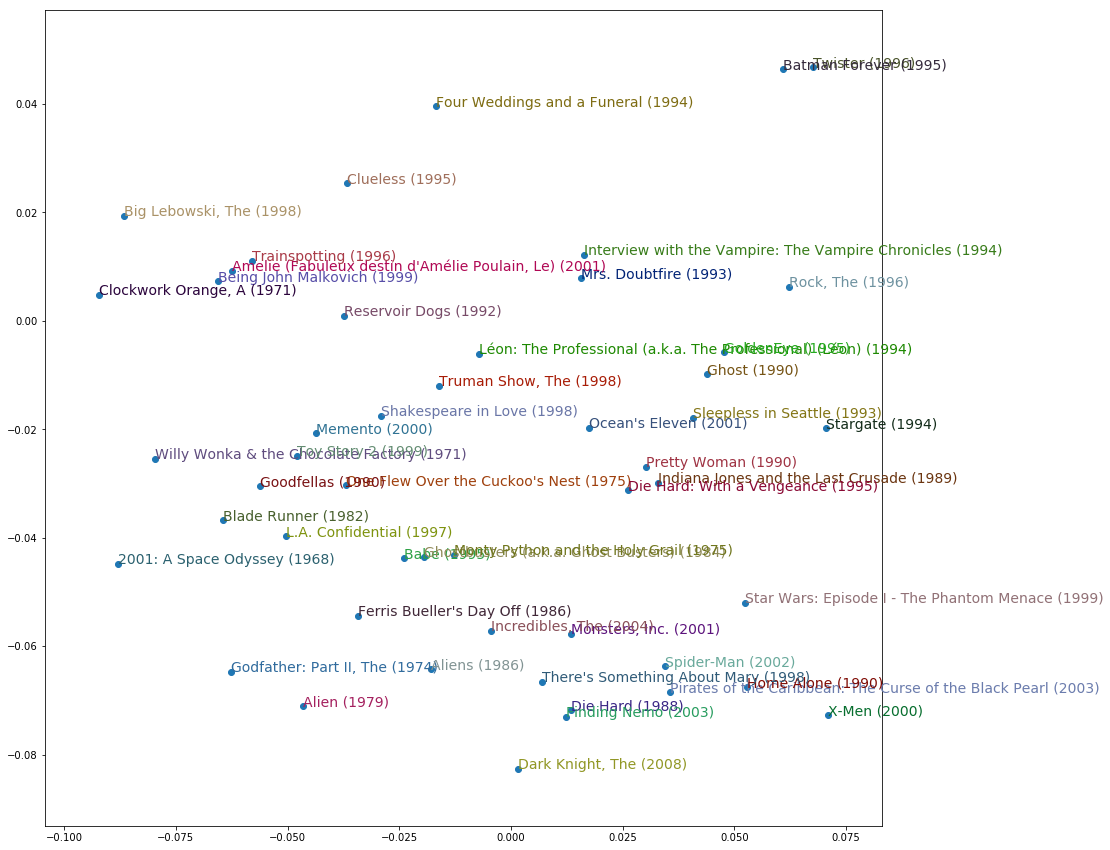

In [67]:
start = 50; end = 100
X = fac0[start:end]
Y = fac1[start:end]
plt.figure(figsize = (15, 15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color = np.random.rand(3) * 0.7, fontsize = 14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [68]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [69]:
x = concatenate([u, m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)

nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

Let's inspect the model

In [70]:
nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_9 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_10 (Embedding)         (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

We then train the model

In [71]:
nn.fit(x = [trn.userId, trn.movieId],
       y = trn.rating,
       batch_size = batch_size,
       epochs = 8, 
       validation_data = ([val.userId, val.movieId], val.rating))

Train on 80041 samples, validate on 19963 samples
Epoch 1/8
80041/80041 [==============================] - 7s - loss: 2.5400 - val_loss: 0.9187
Epoch 2/8
80041/80041 [==============================] - 7s - loss: 1.4721 - val_loss: 0.8851
Epoch 3/8
80041/80041 [==============================] - 7s - loss: 1.2234 - val_loss: 0.8630
Epoch 4/8
80041/80041 [==============================] - 7s - loss: 1.0349 - val_loss: 0.8549
Epoch 5/8
80041/80041 [==============================] - 7s - loss: 0.9116 - val_loss: 0.8383
Epoch 6/8
80041/80041 [==============================] - 7s - loss: 0.8499 - val_loss: 0.8313
Epoch 7/8
80041/80041 [==============================] - 7s - loss: 0.8224 - val_loss: 0.8320
Epoch 8/8
80041/80041 [==============================] - 7s - loss: 0.8123 - val_loss: 0.8306


This improves on our already impressive accuracy even further!

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [72]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending = False)[:2000]
topMovies = np.array(topMovies.index)

We now cannot consider the bias terms. Only the embeddings.

In [73]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use PCA to simplify them down to just 3 vectors.

In [74]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
movie_pca = pca.fit(movie_emb.T).components_

In [75]:
fac0 = movie_pca[0]

In [76]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic' or small/independent.

In [77]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.058057187595790295, 'Battlefield Earth (2000)'),
 (0.056309416497995826, 'Super Mario Bros. (1993)'),
 (0.055257070184890136, 'Police Academy 6: City Under Siege (1989)'),
 (0.05440171441966507, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.054069211297897143, "Charlie's Angels: Full Throttle (2003)"),
 (0.05201436616730408, 'Superman IV: The Quest for Peace (1987)'),
 (0.051414897756137459, 'Wild Wild West (1999)'),
 (0.050201674767934579, 'Bio-Dome (1996)'),
 (0.049907868958498698, 'House on Haunted Hill (1999)'),
 (0.049828140841970313,
  'Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)')]

In [78]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.062636811820419178, 'Shawshank Redemption, The (1994)'),
 (-0.058529108867377354, 'Godfather, The (1972)'),
 (-0.057769670553237049, 'Godfather: Part II, The (1974)'),
 (-0.056686966939466996, 'Philadelphia Story, The (1940)'),
 (-0.054846533899306701, 'Cool Hand Luke (1967)'),
 (-0.05480384201264888, 'Usual Suspects, The (1995)'),
 (-0.054408226155738849, 'Chinatown (1974)'),
 (-0.053877402236154601, 'Fargo (1996)'),
 (-0.052636618946479134, 'African Queen, The (1951)'),
 (-0.052058806846534099, 'North by Northwest (1959)')]

In [79]:
fac1 = movie_pca[1]

In [80]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [81]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.062761525188472583, 'Inside Out (2015)'),
 (0.062459164174865751, 'Battlefield Earth (2000)'),
 (0.062015043805280903, 'Hannibal (2001)'),
 (0.058884127480591866, 'Bicentennial Man (1999)'),
 (0.05855064403555741, 'Volcano (1997)'),
 (0.058307673284360768, 'Stalag 17 (1953)'),
 (0.055929576767238511, 'Mr. Deeds (2002)'),
 (0.053966323356196173, 'Con Air (1997)'),
 (0.053525622102446158, 'Snatch (2000)'),
 (0.052640896181965963, 'Little Nicky (2000)')]

In [82]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.08439633020886185, 'Napoleon Dynamite (2004)'),
 (-0.080797878816099594, 'Batman (1989)'),
 (-0.079322305003935223, "Dracula (Bram Stoker's Dracula) (1992)"),
 (-0.07232820078210532, 'Virgin Suicides, The (1999)'),
 (-0.071502416577592626, 'Arachnophobia (1990)'),
 (-0.0673614966824162, "Things to Do in Denver When You're Dead (1995)"),
 (-0.064576278857699759, 'Lawnmower Man, The (1992)'),
 (-0.064116630782590472, 'Fast Times at Ridgemont High (1982)'),
 (-0.063684909509389334, 'Natural Born Killers (1994)'),
 (-0.063613100936164887, 'Cocoon (1985)')]

In [83]:
fac2 = movie_pca[2]

In [84]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'. Or more likely kid friendly vs. not that.

In [85]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.096763754607299926, 'Chasing Amy (1997)'),
 (0.083573558665504713, "There's Something About Mary (1998)"),
 (0.07967683157510555, 'Scary Movie (2000)'),
 (0.079192285736638932, 'Analyze This (1999)'),
 (0.06806022070702207, 'M (1931)'),
 (0.065518081187811925, 'Superman II (1980)'),
 (0.064758573603732314, 'Cable Guy, The (1996)'),
 (0.064181873612542337, 'Field of Dreams (1989)'),
 (0.06383985931167302, 'Prince of Egypt, The (1998)'),
 (0.063822642800296245, 'Mrs. Doubtfire (1993)')]

In [86]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.070544092409096537, 'Mallrats (1995)'),
 (-0.06883937421403992, 'Sin City (2005)'),
 (-0.068638857650364565, 'Curious Case of Benjamin Button, The (2008)'),
 (-0.06750454792437649, 'Chocolat (2000)'),
 (-0.067113296625721894, 'Silence of the Lambs, The (1991)'),
 (-0.066282850507901878, 'Big Trouble in Little China (1986)'),
 (-0.064060962812114403, 'I Know What You Did Last Summer (1997)'),
 (-0.06115964044110881, 'Godfather: Part II, The (1974)'),
 (-0.060968009203664804, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (-0.060185944337567993, 'Aliens (1986)')]